This Kaggle Notebook is for the project of Machine Learning in ULB. The goal of this project is to create a model that can classify Chest X-Ray images into 2 different classes: Pneumonia or Normal.

# Import

Here are some of the important package that we need to import to run this code.

In [1]:
# All the import necessary for the code
import numpy as np
import os
import pandas as pd
import glob # Used to find the name of a path
import matplotlib.pyplot as plt
import seaborn as sns
import random
import datetime 
import shutil


from skimage.io import imread, imshow, imsave
from skimage.transform import rotate, warp, AffineTransform, resize
from skimage.exposure import adjust_gamma

# Import Data

In this section, we can find the main paths to get the data that has been uploaded in this Kaggel Notebook.

In [2]:
# Define path to the data directory (Training used in the training and testing used to evaluate the final model performs)

#TRAINING
train_dir = "/kaggle/input/dataset-mac/Data/RawData/train"
train_dir_normal = "/kaggle/input/dataset-mac/Data/RawData/train/NORMAL"
train_dir_pneumonia = "/kaggle/input/dataset-mac/Data/RawData/train/PNEUMONIA"


#TESTING
test_dir = "/kaggle/input/dataset-mac/Data/RawData/test"
test_dir_normal = "/kaggle/input/dataset-mac/Data/RawData/test/NORMAL"
test_dir_pneumonia = "/kaggle/input/dataset-mac/Data/RawData/test/PNEUMONIA"

# Representation - Training Data

First, we want to have a better visualization of the dataset that we are working with. The code belows just allows to create a graph to see the distribution between the 2 different classes: Pneumonia or Normal. Then, we can also show some of the images in the dataset to see how they look like (shapes, color, ...)

In [3]:
# We have 2 files: NORMAL and PNEUMONIA 
# Label used: 0 --> NORMAL & 1 --> PNEUMONIA

#Creation of the list
normal_list = os.listdir(train_dir_normal)
pneumonia_list = os.listdir(train_dir_pneumonia)

train_data = []
train_data_normal = []
train_data_pneumonia = []

# Go through all the normal cases (0 --> NORMAL)
for img in normal_list:
    train_data.append((img,0))
    train_data_normal.append((img,0))
train_normal_pd = pd.DataFrame(train_data_normal, columns=['image name', 'label'],index=None)

# Go through all the pneumonia cases (1 --> PNEUMONIA)
for img in pneumonia_list:
    train_data.append((img, 1))
    train_data_pneumonia.append((img,0))
train_pneumonia_pd = pd.DataFrame(train_data_pneumonia, columns=['image name', 'label'],index=None)


train_data_pd = pd.DataFrame(train_data, columns=['image name', 'label'],index=None) # Create DataFrame
train_data_pd = train_data_pd.sample(frac=1.).reset_index(drop=True) # Shuffle the data 

1    3875
0    1341
Name: label, dtype: int64


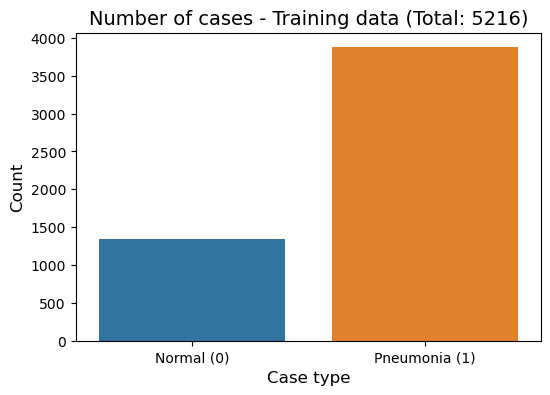

In [4]:
# Get the counts for each class
cases_count_train = train_data_pd['label'].value_counts()
print(cases_count_train)
total_data_train = cases_count_train[0] + cases_count_train[1]

# Plot the results 
plt.figure(figsize=(6,4))
sns.barplot(x=cases_count_train.index, y= cases_count_train.values)
plt.title('Number of cases - Training data (Total: {})'.format(total_data_train), fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count_train.index)), ['Normal (0)', 'Pneumonia (1)'])
plt.show()

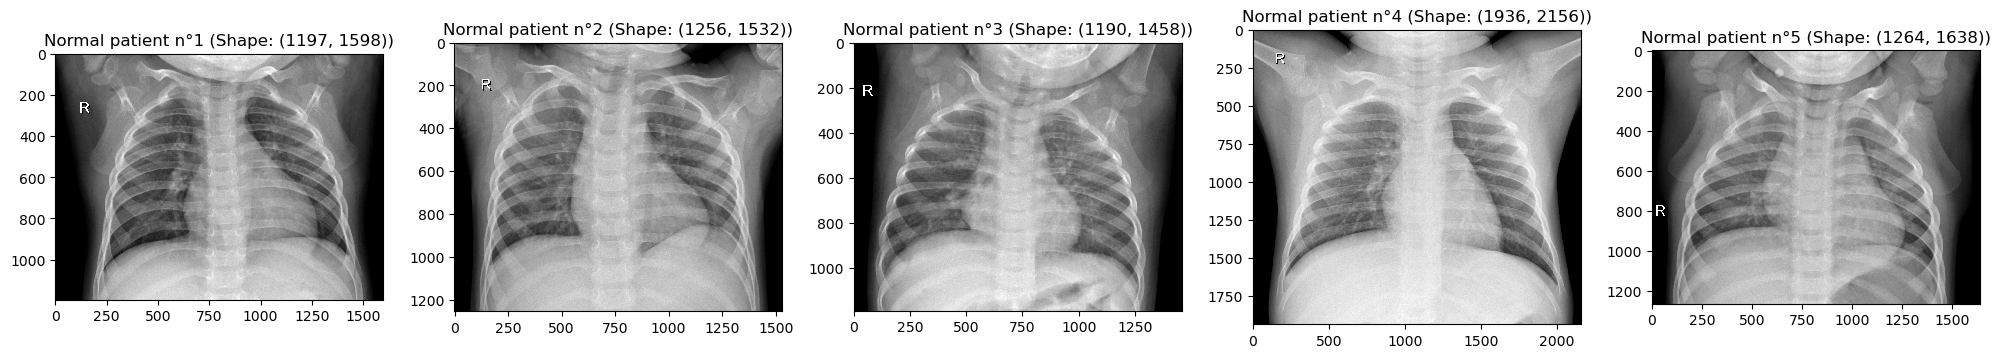

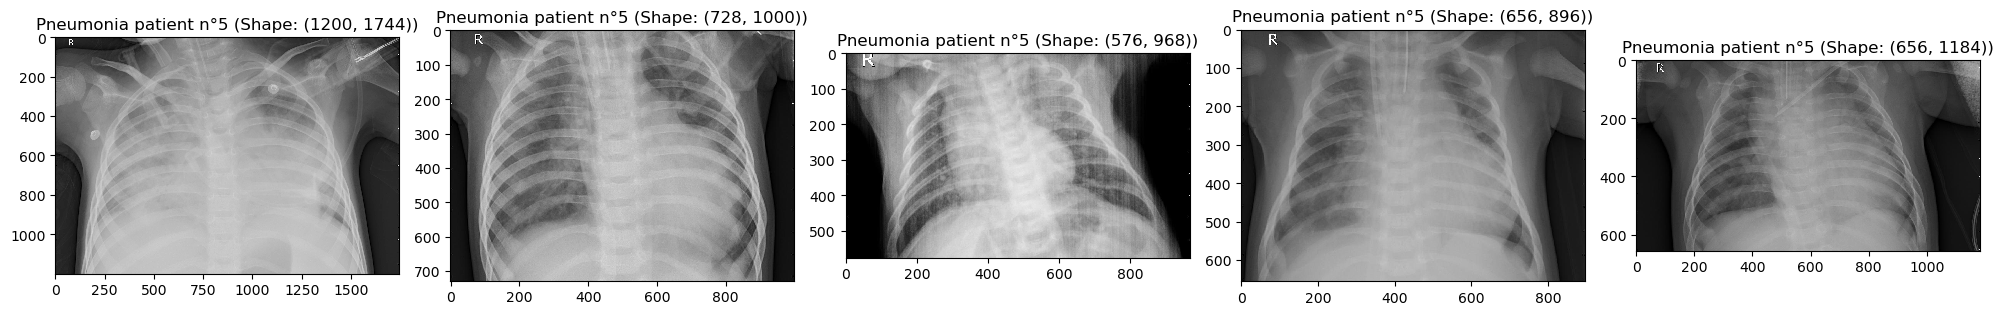

In [43]:
# Get some representation of the pictures to get an idea of what we are working with

# Normal patient
picture_normal = (train_data_pd[train_data_pd['label']==0]['image name'].iloc[:5]).tolist()
picture_normal_path = []
for i in range (len(picture_normal)):
  path = train_dir_normal + '/' + picture_normal[i]
  picture_normal_path.append(path)

# Pneumonia patient
picture_pneumonia = (train_data_pd[train_data_pd['label']==1]['image name'].iloc[:5]).tolist()
picture_pneumonia_path = []
for i in range (len(picture_pneumonia)):
  path = train_dir_pneumonia + '/' + picture_pneumonia[i]
  picture_pneumonia_path.append(path)


plt.figure(figsize=(20,20))
for i in range(len(picture_normal_path)):
  plt.subplot(1,5,i+1)
  imshow(picture_normal_path[i])
  img = imread(picture_normal_path[i])
  shape = img.shape #Images are well in gray level already!
  plt.title('Normal patient n°{} (Shape: {})'.format(i+1, shape))

plt.figure(figsize=(20,20))
for j in range(len(picture_pneumonia_path)):
  plt.subplot(1,5,j+1)
  imshow(picture_pneumonia_path[j])
  img2 = imread(picture_pneumonia_path[j])
  shape2 = img2.shape #Images are  in gray level already!
  plt.title('Pneumonia patient n°{} (Shape: {})'.format(i+1, shape2))

# Preprocessing - Data Augmentation (Training and Validation)

Now that we know how our dataset looks like, we can transform it to have a "better" dataset for the training of the model.
First, we want a symmetrical dataset because otherwise, the model would be more trained to recognize one class and not the other one. To do so, we are going to do a Data Augmentation. Data Augmentation is just the fact that we are going to create synthetics images from the original one. A synthetic image is an image where some parameters has changed from the orignal (and this is done randomely), here I choose some parameters such as:
* **Rotation**: The angle can change between -5 and 5 degree
* **Brightness**: can change between 0.3 and 1.5
* **Vertical shift**: can move from -10 to 11 pixels
* **Horizontal shift**: can move from -10 to 10 pixels

As we do not have any validation set, we need to split the training set into one training set (80% of the raw data) and in one validation set (20% of the raw data). Once this split is over, we can do the data augmentation on both sets. We can also visualize the results at the end to see if you have a symmetrical dataset.

In [5]:
#Random geometric change - Definition of the function here
def data_geometric_change(im):

  #Rotation:
  rot_rand = random.randint(0,1)
  if rot_rand == 1:
    angle_rand = random.randint(-5, 5) #It is a value that I found myself
    im = rotate(im, angle_rand)

  #Brightness:
  bright_rand = random.randint(0,1)
  if bright_rand == 1:
    bright_value = random.uniform(0.3,1.5)
    im = adjust_gamma(im, bright_value)

  #Vertical shift
  vert_rand = random.randint(0,1)
  if vert_rand == 1:
    vert_shift = random.randint(-10, 10)
    im = warp(im, AffineTransform(translation=(0, -vert_shift)))

  #Horizontal shift (this is done for every image to not get twice the same picture at the end!)
  hor_rand = 1
  if hor_rand == 1:
    hor_shift = random.randint(-10,10)
    if hor_shift == 0:
      im = warp(im, AffineTransform(translation=(-5, 0)))
    im = warp(im, AffineTransform(translation=(-hor_shift, 0)))

  return im


In [3]:
#NEW PATH OF THE PROCESSED IMAGES

#TRAINING
train_dir_processed = '/kaggle/input/dataset-mac/Data/Processing/Train'
train_dir_normal_processed = '/kaggle/input/dataset-mac/Data/Processing/Train/NORMAL'
train_dir_pneumonia_processed = '/kaggle/input/dataset-mac/Data/Processing/Train/PNEUMONIA'

#VALIDATION
validation_dir_processed = '/kaggle/input/dataset-mac/Data/Processing/Validation'
validation_dir_normal_processed = '/kaggle/input/dataset-mac/Data/Processing/Validation/NORMAL'
validation_dir_pneumonia_processed = '/kaggle/input/dataset-mac/Data/Processing/Validation/PNEUMONIA'

#TEST
test_dir = '/kaggle/input/dataset-mac/Data/RawData/test'

Split the data to creation one training and one validation set

In [ ]:
#Run only 1 time!
"""
#Remove 20% of the training data (in each category) to put it in the validation files (and then we can do the creation of synthetic images while we are sure that there is no patient in thee training and in the validation at the same time)


pourcent_data = 0.2 #Split pourcentage

#--------------NORMAL-------------------
count_normal = 0
total_image = cases_count_train[0]
limit_normal = int(total_image * pourcent_data)

while count_normal < limit_normal: #20% of data in validation/Normal
  rand_image = random.randint(0,total_image-1)
  image_name = train_normal_pd.iloc[rand_image, 0]
  chemin_source = train_dir_normal + '/' + image_name
  chemin_destination = validation_dir_normal_processed + '/' + image_name
  new_im = imread(chemin_source)
  imsave(chemin_destination, new_im)
  train_normal_pd = train_normal_pd.drop(index=rand_image)
  train_normal_pd = train_normal_pd.reset_index(drop=True)
  count_normal = count_normal + 1
  total_image = total_image - 1

for i in range (total_image-1): #the rest of the data (80%) put in train/normal!
  image_name = train_normal_pd.iloc[i, 0]
  chemin_source = train_dir_normal + '/' + image_name
  chemin_destination = train_dir_normal_processed + '/' + image_name
  new_im = imread(chemin_source)
  imsave(chemin_destination, new_im)

#--------------PNEUMONIA-------------------
count_pneumonia = 0
total_image_pneumonia = cases_count_train[1]
limit_pneumonia = int(total_image_pneumonia * pourcent_data)

while count_pneumonia < limit_pneumonia: #20% of data in validation/Pneumonia
  rand_image = random.randint(0,total_image_pneumonia-1)
  image_name = train_pneumonia_pd.iloc[rand_image, 0]
  chemin_source = train_dir_pneumonia + '/' + image_name
  chemin_destination = validation_dir_pneumonia_processed + '/' + image_name
  new_im = imread(chemin_source)
  imsave(chemin_destination, new_im)
  train_pneumonia_pd = train_pneumonia_pd.drop(index=rand_image)
  train_pneumonia_pd = train_pneumonia_pd.reset_index(drop=True)
  count_pneumonia = count_pneumonia + 1
  total_image_pneumonia = total_image_pneumonia - 1

for i in range (total_image_pneumonia-1): #the rest of the data (80%) put in train/Pneumonia!
  image_name = train_pneumonia_pd.iloc[i, 0]
  chemin_source = train_dir_pneumonia + '/' + image_name
  chemin_destination = train_dir_pneumonia_processed + '/' + image_name
  new_im = imread(chemin_source)
  imsave(chemin_destination, new_im)

"""
  

Data Augmentation - Training

In [ ]:
#Run only 1 time (pre-processing)!

"""
# Creation of the dataframe in the Processed directory

#Creation of the list
normal_list_processed = os.listdir(train_dir_normal_processed)
pneumonia_list_processed = os.listdir(train_dir_pneumonia_processed)

train_data_normal = []
train_data_pneumonia = []

# Go through all the normal cases (0 --> NORMAL)
for img in normal_list_processed:
    train_data_normal.append((img,0))

train_data_normal_pd = pd.DataFrame(train_data_normal, columns=['image name', 'label'],index=None)
# Go through all the pneumonia cases (1 --> PNEUMONIA)
for img in pneumonia_list_processed:
    train_data_pneumonia.append((img, 1))

train_data_pneumonia_pd = pd.DataFrame(train_data_pneumonia, columns=['image name', 'label'],index=None)



pourcent_data = 0.25

#------------PNEUMONIA----------------------
pneumonia_size = len(train_data_pneumonia_pd) - 1
count_max = int(pourcent_data * pneumonia_size)
count = 1

for i in range (count_max):
  value = random.randint(0, pneumonia_size - 1)
  image_name = train_data_pneumonia_pd.iloc[value,0]
  im = imread(train_dir_pneumonia_processed + '/' + image_name)
  new_im = data_geometric_change(im)
  chaine = image_name.split('.')
  new_name = chaine[0]
  path = train_dir_pneumonia_processed + '/' + new_name + "_Synthetic_{}".format(count) + ".jpeg" 
  imsave(path, new_im)
  count += 1

#------------NORMAL----------------------
normal_size = len(train_normal_pd) -1
count_max_nor = (pneumonia_size + count_max) - normal_size 
count_nor = 1

for i in range (count_max_nor):
  value = random.randint(0,  normal_size - 1)
  image_name = train_data_normal_pd.iloc[value,0]
  im = imread(train_dir_normal_processed + '/' + image_name)
  new_im = data_geometric_change(im)
  chaine = image_name.split('.')
  new_name = chaine[0]
  path = train_dir_normal_processed + '/' + new_name + "_Synthetic_{}".format(count_nor) + ".jpeg" 
  imsave(path, new_im)
  count_nor += 1
"""


Data Augmentation - Validation

In [ ]:
#Run only 1 time (pre-processing)!

"""
# Creation of the dataframe in the Processed directory
#Creation of the list
normal_list_processed_val = os.listdir(validation_dir_normal_processed)
pneumonia_list_processed_val = os.listdir(validation_dir_pneumonia_processed)

validation_data_normal = []
validation_data_pneumonia = []

# Go through all the normal cases (0 --> NORMAL)
for img in normal_list_processed_val:
    validation_data_normal.append((img,0))

validation_data_normal_pd = pd.DataFrame(validation_data_normal, columns=['image name', 'label'],index=None)
# Go through all the pneumonia cases (1 --> PNEUMONIA)
for img in pneumonia_list_processed_val:
    validation_data_pneumonia.append((img, 1))

validation_data_pneumonia_pd = pd.DataFrame(validation_data_pneumonia, columns=['image name', 'label'],index=None)

pourcent_data = 0.25

#------------PNEUMONIA----------------------
pneumonia_size = len(validation_data_pneumonia_pd)
count_max = int(pourcent_data * pneumonia_size)
count = 1

for i in range (count_max):
  value = random.randint(0, pneumonia_size - 1)
  image_name = validation_data_pneumonia_pd.iloc[value,0]
  im = imread(validation_dir_pneumonia_processed + '/' + image_name)
  new_im = data_geometric_change(im)
  chaine = image_name.split('.')
  new_name = chaine[0]
  path = validation_dir_pneumonia_processed + '/' + new_name + "_Synthetic_{}".format(count) + ".jpeg" 
  imsave(path, new_im)
  count += 1

#------------NORMAL----------------------
normal_size = len(validation_data_normal_pd)
count_max_nor = (pneumonia_size + count_max) - normal_size 
count_nor = 1

for i in range (count_max_nor):
  value = random.randint(0,  normal_size - 1)
  image_name = validation_data_normal_pd.iloc[value,0]
  im = imread(validation_dir_normal_processed + '/' + image_name)
  new_im = data_geometric_change(im)
  chaine = image_name.split('.')
  new_name = chaine[0]
  path = validation_dir_normal_processed + '/' + new_name + "_Synthetic_{}".format(count_nor) + ".jpeg" 
  imsave(path, new_im)
  count_nor += 1

"""

# Representation of the Data after augmentation

0    3869
1    3859
Name: label, dtype: int64


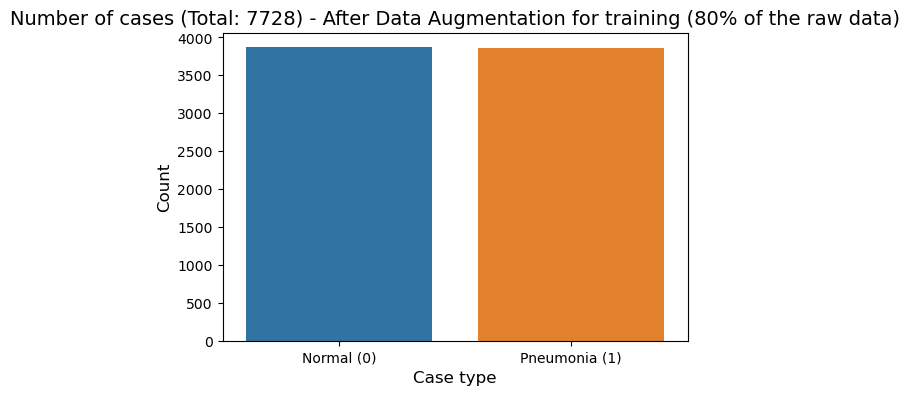

0    968
1    968
Name: label, dtype: int64


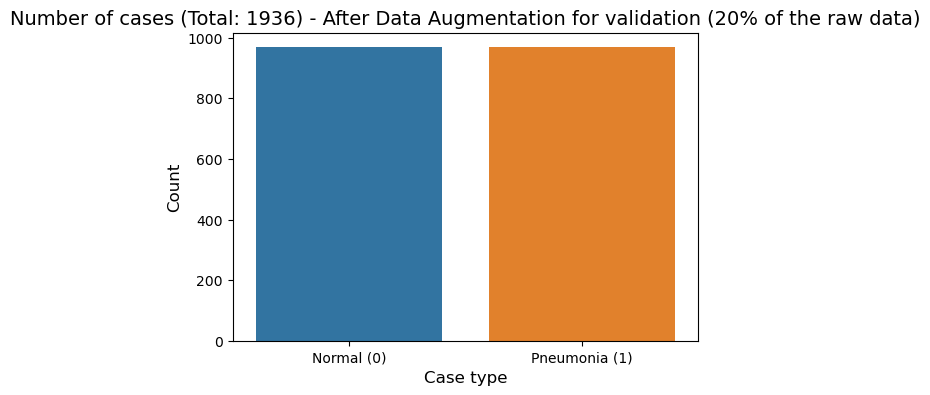

In [6]:
# Label used: 0 --> NORMAL & 1 --> PNEUMONIA

#-----------TRAINING-------------------------------------
normal_list = os.listdir(train_dir_normal_processed)
pneumonia_list = os.listdir(train_dir_pneumonia_processed)
train_data = []

for img in normal_list:
    train_data.append((img,0))

for img in pneumonia_list:
    train_data.append((img, 1))

train_data_pd_augm = pd.DataFrame(train_data, columns=['image name', 'label'],index=None)

cases_count_train = train_data_pd_augm['label'].value_counts()
print(cases_count_train)
total_img = cases_count_train[0] + cases_count_train[1]

# Plot the results 
plt.figure(figsize=(6,4))
sns.barplot(x=cases_count_train.index, y= cases_count_train.values)
plt.title('Number of cases (Total: {}) - After Data Augmentation for training (80% of the raw data)'.format(total_img), fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count_train.index)), ['Normal (0)', 'Pneumonia (1)'])
plt.show()


#-----------VALIDATION-------------------------------------
normal_list_val = os.listdir(validation_dir_normal_processed)
pneumonia_list_val = os.listdir(validation_dir_pneumonia_processed)
train_data_val = []

for img in normal_list_val:
    train_data_val.append((img,0))

for img in pneumonia_list_val:
    train_data_val.append((img, 1))

validation_data_pd_augm = pd.DataFrame(train_data_val, columns=['image name', 'label'],index=None)

cases_count_val = validation_data_pd_augm['label'].value_counts()
print(cases_count_val)
total_img_val = cases_count_val[0] + cases_count_val[1]

# Plot the results 
plt.figure(figsize=(6,4))
sns.barplot(x=cases_count_val.index, y= cases_count_val.values)
plt.title('Number of cases (Total: {}) - After Data Augmentation for validation (20% of the raw data)'.format(total_img_val), fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count_val.index)), ['Normal (0)', 'Pneumonia (1)'])
plt.show()

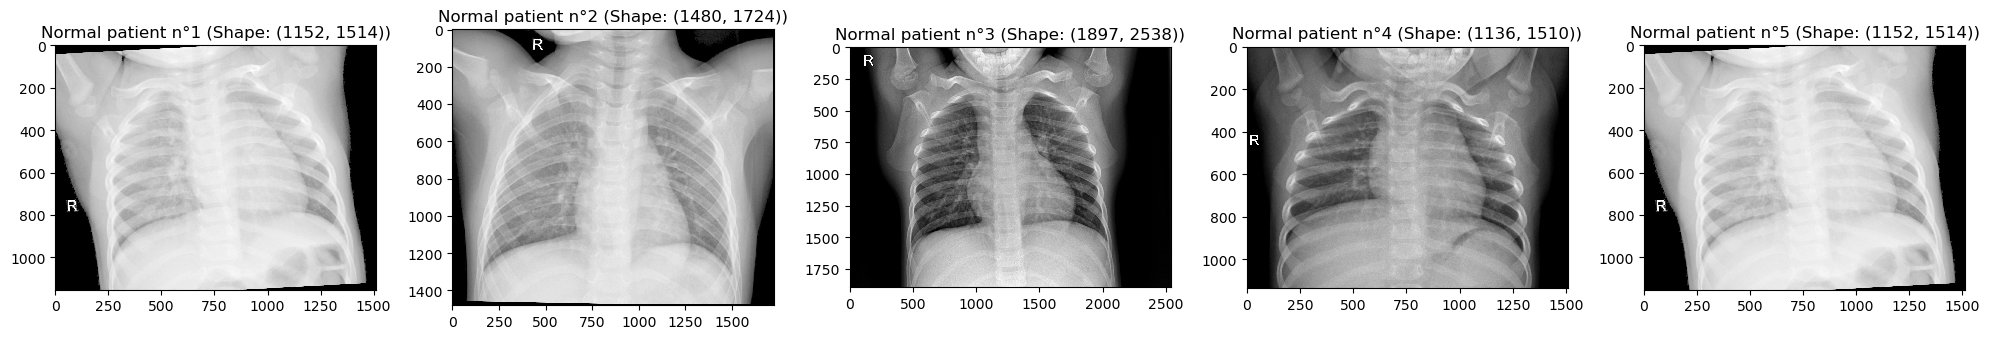

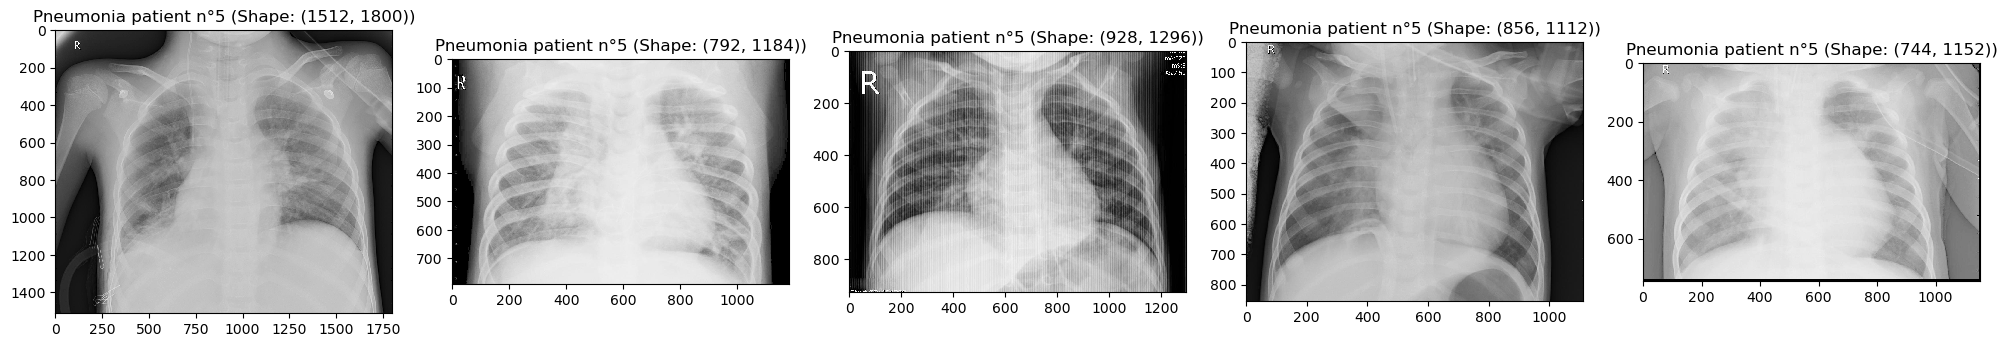

In [47]:
# Get some representation of the pictures to get an idea of what we are working with

# Normal patient
picture_normal = (train_data_pd_augm[train_data_pd_augm['label']==0]['image name'].iloc[:500]).tolist()
picture_normal_path = []
for i in range (len(picture_normal)):
  path = train_dir_normal_processed + '/' + picture_normal[i]
  picture_normal_path.append(path)

# Pneumonia patient
picture_pneumonia = (train_data_pd_augm[train_data_pd_augm['label']==1]['image name'].iloc[:500]).tolist()
picture_pneumonia_path = []
for i in range (len(picture_pneumonia)):
  path = train_dir_pneumonia_processed + '/' + picture_pneumonia[i]
  picture_pneumonia_path.append(path)


plt.figure(figsize=(20,20))
for i in range(5):
  plt.subplot(1,5,i+1)
  rand = random.randint(0,450)
  imshow(picture_normal_path[i + rand])
  img = imread(picture_normal_path[i + rand])
  shape = img.shape #Images are well in gray level already!
  plt.title('Normal patient n°{} (Shape: {})'.format(i+1, shape))

plt.figure(figsize=(20,20))
for j in range(5):
  plt.subplot(1,5,j+1)
  rand = random.randint(0,450)
  imshow(picture_pneumonia_path[j + rand])
  img2 = imread(picture_pneumonia_path[j + rand])
  shape2 = img2.shape #Images are well in gray level already!
  plt.title('Pneumonia patient n°{} (Shape: {})'.format(i+1, shape2))

# Model Pytorch - Constructed model

In this project, we are going to work with the PyTorch library. This first model is a model that I have constructed and then after that, we are going to observe the difference with a pre-trained model.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1), #To make sure that all of the images are in gray
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))  #Neural networks converge much faster if the input data is normalized (values get after running the function above)
])

# Creation of a personalized DataSet for Pytorch (Documentation: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders)
class ChestXrayDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = datasets.ImageFolder(root=data_dir)

    def __getitem__(self, index):
        path, _ = self.image_files.imgs[index]
        image = Image.open(path)

        if self.transform is not None:
            image = self.transform(image)
        label = 1 if 'PNEUMONIA' in path else 0
        return image, label

    def __len__(self):
        return len(self.image_files)


# DataLoader to get the dataset
batch_size = 64

# Training
train_set = ChestXrayDataset(train_dir_processed, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Validation
val_set = ChestXrayDataset(validation_dir_processed, transform=transform)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

Construction of the model

In [5]:
import torch.nn.functional as F
import torchvision
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime 
from tqdm.notebook import tqdm
import os


#Creation of a model (Documentation: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)
class ChestXrayClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 3, kernel_size = 3, stride=2, padding=1) #Stride has the same effect of MaxPooling
        self.conv2 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride=2, padding=1)

        self.fc1 = nn.Linear(32 * 8 * 8, 120)  #  from 8*8 image dimension
        self.fc2 = nn.Linear(120, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))  
        x = self.fc2(x)

        return x

Create a folder that saves everything of the model and then that can be seen into TensorBoard.

In [6]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
chemin_acces_tensorboard = "/kaggle/working//model_constructed_{}".format(timestamp)

writer = SummaryWriter(log_dir= chemin_acces_tensorboard)

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images) # create grid of images

writer.add_image('Example_Dataset', img_grid) # write to tensorboard

Training of the model

In [14]:
#  Defining accuracy function (Source: https://blog.paperspace.com/training-validation-and-accuracy-in-pytorch/)
def accuracy(network, dataloader):
  network.eval()
  total_correct = 0
  total_instances = 0
  for images, labels in tqdm(dataloader):
    images, labels = images.to(device), labels.to(device)
    predictions = torch.argmax(network(images), dim=1)
    correct_predictions = sum(predictions==labels).item()
    total_correct+=correct_predictions
    total_instances+=len(images)
  return round(total_correct/total_instances, 3)


#To be able to use the GPU to have faster
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

#Creation of the model 
model = ChestXrayClassifier().to(device)
images = images.to(device)
writer.add_graph(model, images)

epoch_number = 0
EPOCHS = 10
best_vloss = 1_000_000


# Definition of the loss and optimizer functions
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    running_loss_train = 0.0
    running_loss_val = 0.0
    avg_loss = 0
    
    # Training
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item()

        if i % 10 == 9:
            last_loss = running_loss_train / 10 # loss per batch
            avg_loss = last_loss
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_number * len(train_loader) + i + 1
            writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss_train = 0

    print("Calculating the training accuracy")
    train_accuracy = accuracy(model, train_loader) 

    # Validation
    with torch.no_grad():
        for j, val_data in enumerate(val_loader, 0):
            val_inputs, val_labels = val_data
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            running_loss_val += val_loss.item()

    avg_vloss = running_loss_val / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    print("Calculating the validation accuracy")
    val_accuracy = accuracy(model, val_loader)

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    
    writer.add_scalars('Training vs. Validation Accuracy',
                    { 'Training' : train_accuracy, 'Validation' : val_accuracy },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1


Using cuda device
EPOCH 1:
  batch 10 loss: 0.6680945158004761
  batch 20 loss: 0.5372864723205566
  batch 30 loss: 0.3805755004286766
  batch 40 loss: 0.30014618337154386
  batch 50 loss: 0.2628274172544479
  batch 60 loss: 0.26308573931455614
  batch 70 loss: 0.22001302540302276
  batch 80 loss: 0.22458276599645616
  batch 90 loss: 0.2133455753326416
  batch 100 loss: 0.22784254401922227
  batch 110 loss: 0.1848962314426899
  batch 120 loss: 0.1885921038687229
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.1885921038687229 valid 0.05077018554915081
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 2:
  batch 10 loss: 0.17568424120545387
  batch 20 loss: 0.17192597910761834
  batch 30 loss: 0.15104794651269912
  batch 40 loss: 0.15499204471707345
  batch 50 loss: 0.16986239328980446
  batch 60 loss: 0.18034820780158042
  batch 70 loss: 0.1353806622326374
  batch 80 loss: 0.1349930539727211
  batch 90 loss: 0.15687604919075965
  batch 100 loss: 0.1559538509696722
  batch 110 loss: 0.13774168230593203
  batch 120 loss: 0.12412857040762901
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.12412857040762901 valid 0.03507936313317334
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 3:
  batch 10 loss: 0.10050042532384396
  batch 20 loss: 0.15371541157364846
  batch 30 loss: 0.11337614506483078
  batch 40 loss: 0.10677925124764442
  batch 50 loss: 0.12477749325335026
  batch 60 loss: 0.13052664566785097
  batch 70 loss: 0.1011120904237032
  batch 80 loss: 0.1258490800857544
  batch 90 loss: 0.1145929329097271
  batch 100 loss: 0.1319610070437193
  batch 110 loss: 0.10086116380989552
  batch 120 loss: 0.1249179806560278
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.1249179806560278 valid 0.029276981364843274
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 4:
  batch 10 loss: 0.08928021602332592
  batch 20 loss: 0.08645777441561223
  batch 30 loss: 0.1306013511493802
  batch 40 loss: 0.10370274372398854
  batch 50 loss: 0.09940915070474148
  batch 60 loss: 0.11729658991098404
  batch 70 loss: 0.07867977060377598
  batch 80 loss: 0.07640089727938175
  batch 90 loss: 0.09714095536619424
  batch 100 loss: 0.11103151272982359
  batch 110 loss: 0.08810089156031609
  batch 120 loss: 0.08844204396009445
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.08844204396009445 valid 0.029993258585984058
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 5:
  batch 10 loss: 0.08723089508712292
  batch 20 loss: 0.06762290317565203
  batch 30 loss: 0.07408588398247958
  batch 40 loss: 0.09014995917677879
  batch 50 loss: 0.07020721640437841
  batch 60 loss: 0.06815346162766218
  batch 70 loss: 0.0637980779632926
  batch 80 loss: 0.08203160897828639
  batch 90 loss: 0.10155032984912396
  batch 100 loss: 0.07765530962496996
  batch 110 loss: 0.0920690294355154
  batch 120 loss: 0.06583127407357096
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.06583127407357096 valid 0.030845886479278117
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 6:
  batch 10 loss: 0.05234241187572479
  batch 20 loss: 0.06856258828192949
  batch 30 loss: 0.0962064117193222
  batch 40 loss: 0.07465011589229106
  batch 50 loss: 0.08032734338194132
  batch 60 loss: 0.07078541796654463
  batch 70 loss: 0.06523229852318764
  batch 80 loss: 0.08334487956017256
  batch 90 loss: 0.06965453755110503
  batch 100 loss: 0.0795308256521821
  batch 110 loss: 0.04805493224412203
  batch 120 loss: 0.055906102247536185
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.055906102247536185 valid 0.025858266196359902
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 7:
  batch 10 loss: 0.06866115760058164
  batch 20 loss: 0.046184614300727844
  batch 30 loss: 0.045362023450434205
  batch 40 loss: 0.06463755797594786
  batch 50 loss: 0.05458003766834736
  batch 60 loss: 0.0605949530377984
  batch 70 loss: 0.06399238705635071
  batch 80 loss: 0.09014840759336948
  batch 90 loss: 0.05648723281919956
  batch 100 loss: 0.057732542417943476
  batch 110 loss: 0.04251648290082812
  batch 120 loss: 0.0659051981754601
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.0659051981754601 valid 0.023786034400397834
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 8:
  batch 10 loss: 0.03974255872890353
  batch 20 loss: 0.05907872226089239
  batch 30 loss: 0.04550372054800391
  batch 40 loss: 0.038440583180636166
  batch 50 loss: 0.04664733055979013
  batch 60 loss: 0.059026913018897176
  batch 70 loss: 0.03534279372543096
  batch 80 loss: 0.039077066257596015
  batch 90 loss: 0.041712024994194505
  batch 100 loss: 0.046854895912110804
  batch 110 loss: 0.04953877627849579
  batch 120 loss: 0.08429460600018501
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.08429460600018501 valid 0.027653287553559405
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 9:
  batch 10 loss: 0.04993973672389984
  batch 20 loss: 0.041820095758885144
  batch 30 loss: 0.04782364955171943
  batch 40 loss: 0.03222582703456282
  batch 50 loss: 0.03450390421785414
  batch 60 loss: 0.03825138797983527
  batch 70 loss: 0.04115630621090531
  batch 80 loss: 0.05471771266311407
  batch 90 loss: 0.026165139954537155
  batch 100 loss: 0.0377211207523942
  batch 110 loss: 0.05760396369732916
  batch 120 loss: 0.056346391793340445
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.056346391793340445 valid 0.024164711713044296
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 10:
  batch 10 loss: 0.02338920785114169
  batch 20 loss: 0.018273327872157095
  batch 30 loss: 0.0210114894551225
  batch 40 loss: 0.03361064505297691
  batch 50 loss: 0.01955316518433392
  batch 60 loss: 0.017700979998335243
  batch 70 loss: 0.028832762851379812
  batch 80 loss: 0.03993079042993486
  batch 90 loss: 0.03426975253969431
  batch 100 loss: 0.02545707728713751
  batch 110 loss: 0.07934081107378006
  batch 120 loss: 0.07593090180307627
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.07593090180307627 valid 0.05331904429091864
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

Summary of the model

In [12]:
!pip install torchsummary
from torchsummary import summary

summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 64, 64]              30
            Conv2d-2            [-1, 6, 32, 32]             168
            Conv2d-3           [-1, 16, 16, 16]             880
            Conv2d-4             [-1, 32, 8, 8]           4,640
            Linear-5                  [-1, 120]         245,880
            Linear-6                    [-1, 2]             242
Total params: 251,840
Trainable params: 251,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.19
Params size (MB): 0.96
Estimated Total Size (MB): 1.21
----------------------------------------------------------------


# Representation - Testing Data

In [18]:
# We have 2 files: NORMAL and PNEUMONIA 
# Label used: 0 --> NORMAL & 1 --> PNEUMONIA

#Creation of the list
normal_list_test = os.listdir(test_dir_normal)
pneumonia_list_test = os.listdir(test_dir_pneumonia)

test_data = []

# Go through all the normal cases (0 --> NORMAL)
for img in normal_list_test:
    test_data.append((img,0))

# Go through all the pneumonia cases (1 --> PNEUMONIA)
for img in pneumonia_list_test:
    test_data.append((img, 1))


# Get a pandas dataframe from the data we have in our list 
test_data_pd = pd.DataFrame(test_data, columns=['image name', 'label'],index=None)

# Shuffle the data 
test_data_pd = test_data_pd.sample(frac=1.).reset_index(drop=True)

1    390
0    234
Name: label, dtype: int64


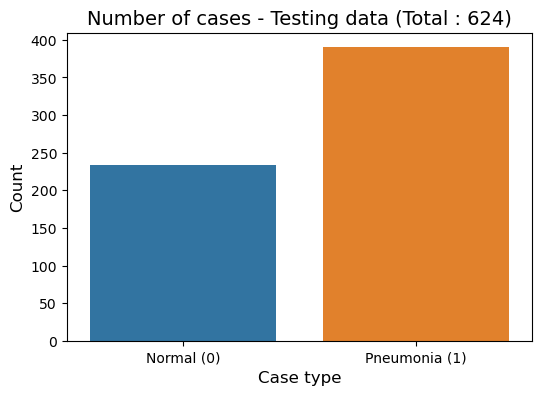

In [19]:
# Get the counts for each class
cases_count_test = test_data_pd['label'].value_counts()
print(cases_count_test)
total_data_test = cases_count_test[0] + cases_count_test[1]

# Plot the results 
plt.figure(figsize=(6,4))
sns.barplot(x=cases_count_test.index, y= cases_count_test.values)
plt.title('Number of cases - Testing data (Total : {})'.format(total_data_test), fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count_test.index)), ['Normal (0)', 'Pneumonia (1)'])
plt.show()

# Testing - Constructed Model

In [20]:
import torchvision.models as models

# Load the test data
test_set = ChestXrayDataset(test_dir, transform=transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

model = ChestXrayClassifier()
model.load_state_dict(torch.load('/kaggle/working/model_20230501_192423_8'))
model.to(device)

model.eval() #Set the model in evaluation mode

correct = 0
total = 0

y_pred = [] #For the confusion matrix
y_true = []

with torch.no_grad(): # Turn off of the gradiant calculation to optimize the evaluation process
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) #Get the class with the highest proba

        output2 = (torch.max(torch.exp(outputs), 1)[1]).cpu().numpy()
        y_pred.extend(output2) # Save Prediction

        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
        labels = labels.data.numpy()
        y_true.extend(labels) # Save Truth

# Calcul of the accuracy of the model
accuracy = 100 * correct / total
print('Accuracy on test set: {:.2f}%'.format(accuracy))

Accuracy on test set: 78.21%


# Confusion matrix - Constructed model

The confusion matrix is a useful tool to observe how the model classify the different images. (Where it is right and when it is wrong)

<AxesSubplot:>

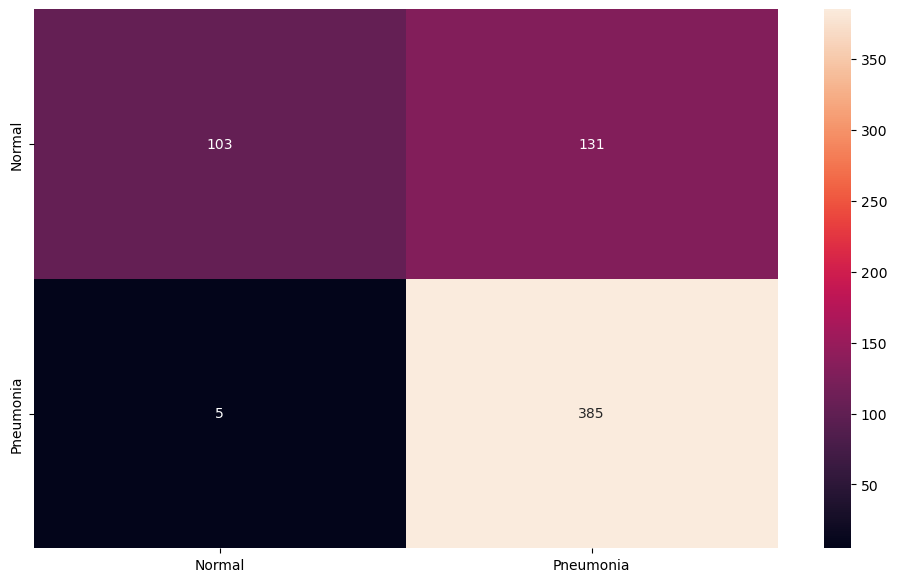

In [21]:
from sklearn.metrics import confusion_matrix

# constant for classes
classes = ('Normal', 'Pneumonia')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index=[i for i in classes], columns=[i for i in classes])
plt.figure(figsize=(12, 7))
sns.heatmap(df_cm, annot=True, fmt='g')

# Pretrained model - AlexNet Model

In [6]:
#To be able to use the GPU to have faster
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Images have to be in RGB to be used in the model, so there are some differences with the previous code

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) #Neural networks converge much faster if the input data is normalized (values get after running the function above)
])


# Creation of a personalized DataSet for Pytorch (Documentation: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders)
class ChestXrayDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = datasets.ImageFolder(root=data_dir)

    def __getitem__(self, index):
        path, _ = self.image_files.imgs[index]
        image = Image.open(path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)
        label = 1 if 'PNEUMONIA' in path else 0
        return image, label

    def __len__(self):
        return len(self.image_files)

# DataLoader to get the dataset
batch_size = 64

# Training
train_set = ChestXrayDataset(train_dir_processed, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Validation
val_set = ChestXrayDataset(validation_dir_processed, transform=transform)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [8]:
import torch.nn.functional as F
import torchvision
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime 
from tqdm.notebook import tqdm
import os

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
chemin_acces_tensorboard = "/kaggle/working/alexnet_{}".format(timestamp)

writer = SummaryWriter(log_dir= chemin_acces_tensorboard)

dataiter = iter(train_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)

writer.add_image('Example_images', img_grid) # write to tensorboard

Import of the model

In [9]:
import torchvision.models as models
model_alexnet = models.alexnet(pretrained=True).to(device)

torch.backends.cudnn.benchmark = True #To have a faster model training

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Training code for the AlexNet pretrained model. There is a difference in the optimizer function, here we are using the SDG optimizer (before we used the ADAM)

In [12]:
#  Defining accuracy function
def accuracy(network, dataloader):
  network.eval()
  total_correct = 0
  total_instances = 0
  for images, labels in tqdm(dataloader):
    images, labels = images.to(device), labels.to(device)
    predictions = torch.argmax(network(images), dim=1)
    correct_predictions = sum(predictions==labels).item()
    total_correct+=correct_predictions
    total_instances+=len(images)
  return round(total_correct/total_instances, 3)

#Creation of the model
images = images.to(device)
writer.add_graph(model_alexnet, images)

epoch_number = 0
EPOCHS = 10
best_vloss = 1_000_000

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_alexnet.parameters(), lr=0.001, momentum=0.9)

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    running_loss_train = 0.0
    running_loss_val = 0.0
    avg_loss = 0
    
    # Training
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item()

        if i % 10 == 9:
            last_loss = running_loss_train / 10 # loss per batch
            avg_loss = last_loss
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_number * len(train_loader) + i + 1
            writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss_train = 0

    print("Calculating the training accuracy")
    train_accuracy = accuracy(model_alexnet, train_loader) 

    # Validation
    with torch.no_grad():
        for j, val_data in enumerate(val_loader, 0):
            val_inputs, val_labels = val_data
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model_alexnet(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            running_loss_val += val_loss.item()

    avg_vloss = running_loss_val / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    print("Calculating the validation accuracy")
    val_accuracy = accuracy(model_alexnet, val_loader)

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    
    writer.add_scalars('Training vs. Validation Accuracy',
                    { 'Training' : train_accuracy, 'Validation' : val_accuracy },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_alexnet_{}_{}'.format(timestamp, epoch_number)
        torch.save(model_alexnet.state_dict(), model_path)

    epoch_number += 1


EPOCH 1:
  batch 10 loss: 0.6661975994706154
  batch 20 loss: 0.41772410571575164
  batch 30 loss: 0.27346940636634826
  batch 40 loss: 0.23746836185455322
  batch 50 loss: 0.22836366593837737
  batch 60 loss: 0.19064736887812614
  batch 70 loss: 0.17481125220656396
  batch 80 loss: 0.15895468592643738
  batch 90 loss: 0.13336216956377028
  batch 100 loss: 0.15648412555456162
  batch 110 loss: 0.16333960443735124
  batch 120 loss: 0.14086769446730613
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.14086769446730613 valid 0.05604111173474961
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 2:
  batch 10 loss: 0.18127076029777528
  batch 20 loss: 0.10780446454882622
  batch 30 loss: 0.1259649571031332
  batch 40 loss: 0.09476772956550121
  batch 50 loss: 0.06769566647708417
  batch 60 loss: 0.06473044976592064
  batch 70 loss: 0.06305897897109389
  batch 80 loss: 0.08774920478463173
  batch 90 loss: 0.07369703091681004
  batch 100 loss: 0.07176020499318839
  batch 110 loss: 0.06351010240614414
  batch 120 loss: 0.06574696907773614
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.06574696907773614 valid 0.023180553576070045
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 3:
  batch 10 loss: 0.049028285034000876
  batch 20 loss: 0.06069009229540825
  batch 30 loss: 0.06282591139897704
  batch 40 loss: 0.05039008613675833
  batch 50 loss: 0.06932514999061823
  batch 60 loss: 0.05677142795175314
  batch 70 loss: 0.06954088360071183
  batch 80 loss: 0.05693188365548849
  batch 90 loss: 0.06435877867043019
  batch 100 loss: 0.061528407875448464
  batch 110 loss: 0.045600826293230055
  batch 120 loss: 0.04715082058683038
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.04715082058683038 valid 0.024457446820716457
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 4:
  batch 10 loss: 0.07048024628311396
  batch 20 loss: 0.04526809472590685
  batch 30 loss: 0.07988430112600327
  batch 40 loss: 0.07026696130633354
  batch 50 loss: 0.04962941696867347
  batch 60 loss: 0.03203022684901953
  batch 70 loss: 0.02745983302593231
  batch 80 loss: 0.08013385105878115
  batch 90 loss: 0.06735775470733643
  batch 100 loss: 0.049120457284152506
  batch 110 loss: 0.05937238037586212
  batch 120 loss: 0.044809469720348716
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.044809469720348716 valid 0.02088865663323259
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 5:
  batch 10 loss: 0.024406809406355024
  batch 20 loss: 0.028471710439771414
  batch 30 loss: 0.03348287539556623
  batch 40 loss: 0.04247026254888624
  batch 50 loss: 0.03086966669652611
  batch 60 loss: 0.04551279442384839
  batch 70 loss: 0.0434189741499722
  batch 80 loss: 0.054778654547408226
  batch 90 loss: 0.0508279207162559
  batch 100 loss: 0.03986101732589305
  batch 110 loss: 0.050292485672980544
  batch 120 loss: 0.03390989853069186
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.03390989853069186 valid 0.020010732122011914
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 6:
  batch 10 loss: 0.02417097280267626
  batch 20 loss: 0.024112659599632026
  batch 30 loss: 0.024865472782403232
  batch 40 loss: 0.03246177155524492
  batch 50 loss: 0.031715436140075326
  batch 60 loss: 0.022001792467199265
  batch 70 loss: 0.025050235260277987
  batch 80 loss: 0.011998568382114171
  batch 90 loss: 0.018463558796793223
  batch 100 loss: 0.02037385213188827
  batch 110 loss: 0.025956414523534477
  batch 120 loss: 0.021565973898395895
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.021565973898395895 valid 0.020058832633066615
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 7:
  batch 10 loss: 0.02348691604565829
  batch 20 loss: 0.013640321302227676
  batch 30 loss: 0.029643350886180996
  batch 40 loss: 0.03507019418757409
  batch 50 loss: 0.07027115589007735
  batch 60 loss: 0.06935079535469413
  batch 70 loss: 0.020910006016492844
  batch 80 loss: 0.02576546184718609
  batch 90 loss: 0.02660298577975482
  batch 100 loss: 0.015358148142695427
  batch 110 loss: 0.016353573463857175
  batch 120 loss: 0.021540730458218603
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.021540730458218603 valid 0.018203821781400228
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 8:
  batch 10 loss: 0.018722964823246
  batch 20 loss: 0.02169061452150345
  batch 30 loss: 0.019421155843883754
  batch 40 loss: 0.015976402373053134
  batch 50 loss: 0.02496365671977401
  batch 60 loss: 0.022407003759872167
  batch 70 loss: 0.022257929318584502
  batch 80 loss: 0.0490767371840775
  batch 90 loss: 0.05770803838968277
  batch 100 loss: 0.017339984816499055
  batch 110 loss: 0.012577008758671581
  batch 120 loss: 0.01926378277130425
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.01926378277130425 valid 0.017557907445464007
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 9:
  batch 10 loss: 0.012509864516323433
  batch 20 loss: 0.011173507780767977
  batch 30 loss: 0.0069303364027291535
  batch 40 loss: 0.012551788578275592
  batch 50 loss: 0.006779666850343346
  batch 60 loss: 0.012781365995761008
  batch 70 loss: 0.008559203578624875
  batch 80 loss: 0.007940975564997644
  batch 90 loss: 0.0046654324338305745
  batch 100 loss: 0.005167563183931634
  batch 110 loss: 0.005421606528398115
  batch 120 loss: 0.018306208157446234
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.018306208157446234 valid 0.019613293575629024
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 10:
  batch 10 loss: 0.01111139390268363
  batch 20 loss: 0.008429395034909248
  batch 30 loss: 0.014727217983454466
  batch 40 loss: 0.005425704875960946
  batch 50 loss: 0.007906511204782873
  batch 60 loss: 0.0038868165109306576
  batch 70 loss: 0.014038743311539292
  batch 80 loss: 0.01070302898006048
  batch 90 loss: 0.010489766410319134
  batch 100 loss: 0.014795495045837015
  batch 110 loss: 0.040463828065549025
  batch 120 loss: 0.025762558690621516
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.025762558690621516 valid 0.027173492435124427
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

In [13]:
!pip install torchsummary
from torchsummary import summary

summary(model_alexnet, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

# Testing - AlexNet Model 

In [14]:
import torchvision.models as models

# Load the test data
test_set = ChestXrayDataset(test_dir, transform=transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

model = models.alexnet(pretrained=True).to(device)
model.load_state_dict(torch.load('/kaggle/working/model_alexnet_20230502_075715_7'))
model.to(device)

model.eval() #Set the model in evaluation mode

correct = 0
total = 0

y_pred = [] #For the confusion matrix
y_true = []

with torch.no_grad(): # Turn off of the gradiant calculation to optimize the evaluation process
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) #Get the class with the highest proba

        output2 = (torch.max(torch.exp(outputs), 1)[1]).cpu().numpy()
        y_pred.extend(output2) # Save Prediction

        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
        labels = labels.data.numpy()
        y_true.extend(labels) # Save Truth

# Calcul of the accuracy of the model
accuracy = 100 * correct / total
print('Accuracy on test set: {:.2f}%'.format(accuracy))

Accuracy on test set: 83.17%


# Confusion matrix - AlexNet Model

<AxesSubplot:>

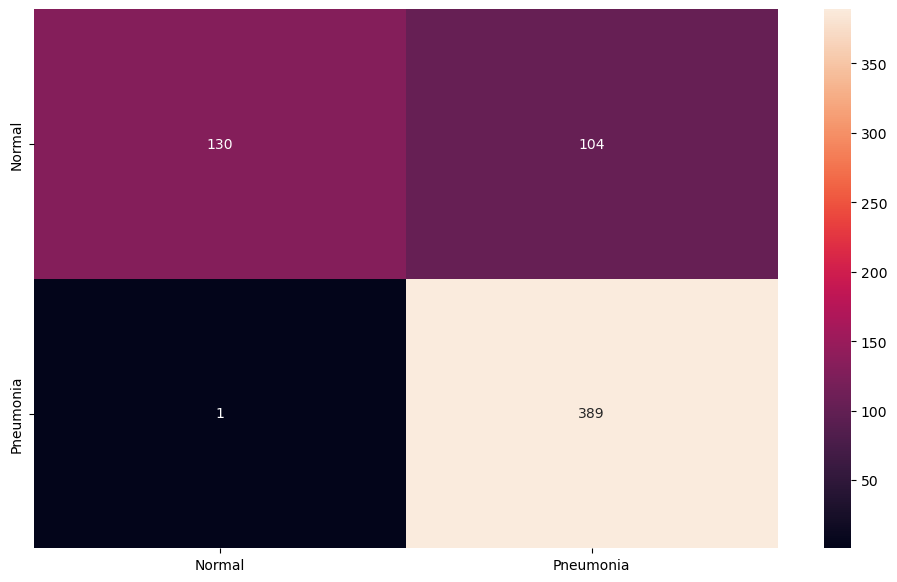

In [15]:
from sklearn.metrics import confusion_matrix

# constant for classes
classes = ('Normal', 'Pneumonia')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index=[i for i in classes], columns=[i for i in classes])
plt.figure(figsize=(12, 7))
sns.heatmap(df_cm, annot=True, fmt='g')

# Pretrained Model - VGG16 Model

This was just a test with another pretrained model to see if you get close to the AlexNet model or not. 

In [16]:
#To be able to use the GPU to have faster
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) #Neural networks converge much faster if the input data is normalized (values get after running the function above)
])


# Creation of a personalized DataSet for Pytorch (Documentation: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders)
class ChestXrayDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = datasets.ImageFolder(root=data_dir)

    def __getitem__(self, index):
        path, _ = self.image_files.imgs[index]
        image = Image.open(path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)
        label = 1 if 'PNEUMONIA' in path else 0
        return image, label

    def __len__(self):
        return len(self.image_files)

# DataLoader to get the dataset
batch_size = 64

# Training
train_set = ChestXrayDataset(train_dir_processed, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Validation
val_set = ChestXrayDataset(validation_dir_processed, transform=transform)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [19]:
import torch.nn.functional as F
import torchvision
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime 
from tqdm.notebook import tqdm
import os

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
chemin_acces_tensorboard = "/kaggle/working/vgg16_{}".format(timestamp)

writer = SummaryWriter(log_dir= chemin_acces_tensorboard)

dataiter = iter(train_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)

writer.add_image('Example_images', img_grid) # write to tensorboard

Import of the model

In [20]:
import torchvision.models as models
model_vgg16 = models.vgg16(pretrained=True).to(device)

torch.backends.cudnn.benchmark = True #To have a faster model training

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Training of the model

In [21]:
#  Defining accuracy function
def accuracy(network, dataloader):
  network.eval()
  total_correct = 0
  total_instances = 0
  for images, labels in tqdm(dataloader):
    images, labels = images.to(device), labels.to(device)
    predictions = torch.argmax(network(images), dim=1)
    correct_predictions = sum(predictions==labels).item()
    total_correct+=correct_predictions
    total_instances+=len(images)
  return round(total_correct/total_instances, 3)

#Creation of the model
images = images.to(device)
writer.add_graph(model_vgg16, images)

epoch_number = 0
EPOCHS = 10
best_vloss = 1_000_000

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9)

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    running_loss_train = 0.0
    running_loss_val = 0.0
    avg_loss = 0
    
    # Training
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item()

        if i % 10 == 9:
            last_loss = running_loss_train / 10 # loss per batch
            avg_loss = last_loss
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_number * len(train_loader) + i + 1
            writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss_train = 0

    print("Calculating the training accuracy")
    train_accuracy = accuracy(model_vgg16, train_loader) 

    # Validation
    with torch.no_grad():
        for j, val_data in enumerate(val_loader, 0):
            val_inputs, val_labels = val_data
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model_vgg16(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            running_loss_val += val_loss.item()

    avg_vloss = running_loss_val / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    print("Calculating the validation accuracy")
    val_accuracy = accuracy(model_vgg16, val_loader)

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    
    writer.add_scalars('Training vs. Validation Accuracy',
                    { 'Training' : train_accuracy, 'Validation' : val_accuracy },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_vgg16_{}_{}'.format(timestamp, epoch_number)
        torch.save(model_vgg16.state_dict(), model_path)

    epoch_number += 1


EPOCH 1:
  batch 10 loss: 2.346456900238991
  batch 20 loss: 0.8326112493872643
  batch 30 loss: 0.4446477621793747
  batch 40 loss: 0.2287890985608101
  batch 50 loss: 0.15583128705620766
  batch 60 loss: 0.1377892941236496
  batch 70 loss: 0.11862730607390404
  batch 80 loss: 0.09788078404963016
  batch 90 loss: 0.08807629272341728
  batch 100 loss: 0.09360534846782684
  batch 110 loss: 0.08966714516282082
  batch 120 loss: 0.13901115637272596
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.13901115637272596 valid 0.03950258904359927
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 2:
  batch 10 loss: 0.1198937987908721
  batch 20 loss: 0.14034840241074562
  batch 30 loss: 0.10617763958871365
  batch 40 loss: 0.08339227978140115
  batch 50 loss: 0.04667321788147092
  batch 60 loss: 0.042311772145330905
  batch 70 loss: 0.04140379931777716
  batch 80 loss: 0.06485318206250668
  batch 90 loss: 0.0441717145498842
  batch 100 loss: 0.0391047665849328
  batch 110 loss: 0.07229251489043236
  batch 120 loss: 0.08012428944930435
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.08012428944930435 valid 0.029873917208337958
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 3:
  batch 10 loss: 0.07705704551190137
  batch 20 loss: 0.042320267111063
  batch 30 loss: 0.03176501970738173
  batch 40 loss: 0.031546625681221484
  batch 50 loss: 0.02754618488252163
  batch 60 loss: 0.02879249572288245
  batch 70 loss: 0.030851070024073123
  batch 80 loss: 0.014492131117731333
  batch 90 loss: 0.017984671238809823
  batch 100 loss: 0.011948810826288537
  batch 110 loss: 0.017762484354898335
  batch 120 loss: 0.011821296182461083
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.011821296182461083 valid 0.018079255124282722
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 4:
  batch 10 loss: 0.02028601700440049
  batch 20 loss: 0.015021521446760744
  batch 30 loss: 0.021279288385994733
  batch 40 loss: 0.012817434879252687
  batch 50 loss: 0.0190445302054286
  batch 60 loss: 0.01649118640925735
  batch 70 loss: 0.027958218986168504
  batch 80 loss: 0.022116893064230682
  batch 90 loss: 0.030889554193709045
  batch 100 loss: 0.00903260150225833
  batch 110 loss: 0.010947369877249003
  batch 120 loss: 0.00785539874341339
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.00785539874341339 valid 0.015818291588365063
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 5:
  batch 10 loss: 0.005436103011015802
  batch 20 loss: 0.005730049434350804
  batch 30 loss: 0.004830684972694144
  batch 40 loss: 0.004468291699595284
  batch 50 loss: 0.013977834291290491
  batch 60 loss: 0.004465142189292237
  batch 70 loss: 0.0023302531626541167
  batch 80 loss: 0.01743335499195382
  batch 90 loss: 0.010212991689331829
  batch 100 loss: 0.008159120107302442
  batch 110 loss: 0.002307976398151368
  batch 120 loss: 0.0037488997273612767
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.0037488997273612767 valid 0.014884514079102332
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 6:
  batch 10 loss: 0.0081495787773747
  batch 20 loss: 0.003220022184541449
  batch 30 loss: 0.0021558791282586753
  batch 40 loss: 0.004724075272679329
  batch 50 loss: 0.0033688485040329398
  batch 60 loss: 0.002836251209373586
  batch 70 loss: 0.0014986425114329905
  batch 80 loss: 0.0027082704371423462
  batch 90 loss: 0.0014748690635315142
  batch 100 loss: 0.0019135123202431714
  batch 110 loss: 0.0010643539688317105
  batch 120 loss: 0.0033015800509019755
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.0033015800509019755 valid 0.019596900084372676
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 7:
  batch 10 loss: 0.000892327486872091
  batch 20 loss: 0.0007459154650860001
  batch 30 loss: 0.0026528519359999337
  batch 40 loss: 0.0016950594610534609
  batch 50 loss: 0.0010236099071335048
  batch 60 loss: 0.0010134296317119151
  batch 70 loss: 0.000718228720506886
  batch 80 loss: 0.001023540679307189
  batch 90 loss: 0.000649602860721643
  batch 100 loss: 0.0024100214563077317
  batch 110 loss: 0.0035102447827739525
  batch 120 loss: 0.000993644807022065
Calculating the training accuracy


  0%|          | 0/121 [00:00<?, ?it/s]

LOSS train 0.000993644807022065 valid 0.021246554045265004
Calculating the validation accuracy


  0%|          | 0/31 [00:00<?, ?it/s]

EPOCH 8:


KeyboardInterrupt: 

In [22]:
!pip install torchsummary
from torchsummary import summary

summary(model_vgg16, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

# Testing - VGG16 Model

In [23]:
import torchvision.models as models

# Load the test data
test_set = ChestXrayDataset(test_dir, transform=transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

model = models.vgg16(pretrained=True).to(device)
model.load_state_dict(torch.load('/kaggle/working/model_vgg16_20230502_092541_4'))
model.to(device)

model.eval() #Set the model in evaluation mode

correct = 0
total = 0

y_pred = [] #For the confusion matrix
y_true = []

with torch.no_grad(): # Turn off of the gradiant calculation to optimize the evaluation process
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) #Get the class with the highest proba

        output2 = (torch.max(torch.exp(outputs), 1)[1]).cpu().numpy()
        y_pred.extend(output2) # Save Prediction

        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
        labels = labels.data.numpy()
        y_true.extend(labels) # Save Truth

# Calcul of the accuracy of the model
accuracy = 100 * correct / total
print('Accuracy on test set: {:.2f}%'.format(accuracy))

Accuracy on test set: 82.69%


# Confusion matrix - VGG16 Model

<AxesSubplot:>

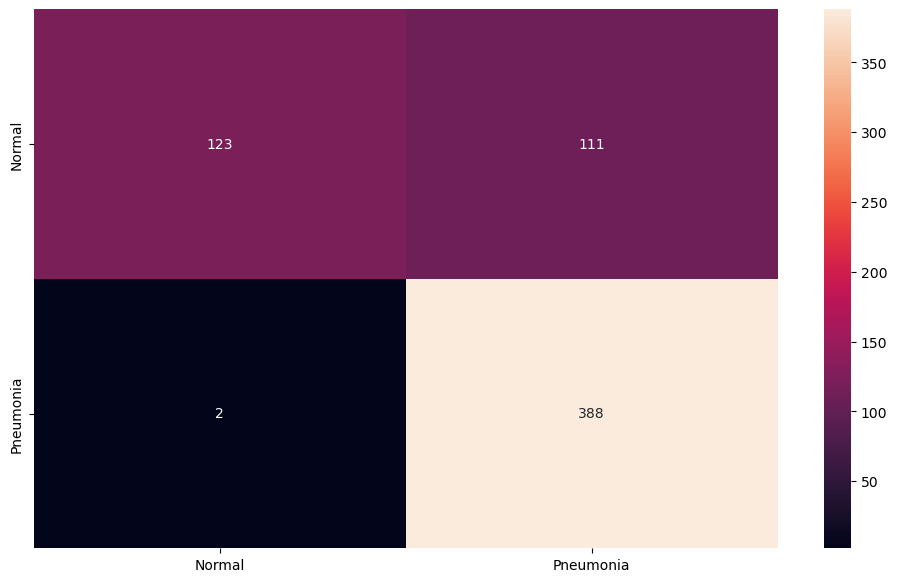

In [36]:
from sklearn.metrics import confusion_matrix

# constant for classes
classes = ('Normal', 'Pneumonia')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index=[i for i in classes], columns=[i for i in classes])
plt.figure(figsize=(12, 7))
sns.heatmap(df_cm, annot=True, fmt='g')